In [1]:
import csv
from collections import defaultdict
from constants import *
import pandas as pd
from statsmodels.stats.proportion import proportion_confint 
import numpy as np  
import matplotlib.pyplot as plt


In [2]:
valid_users = set()
user_train_count = defaultdict(int)     # number of training grids completed for each user
user_test_count = defaultdict(int)      # number of test grids completed for each user
user_train_score = defaultdict(int)     # cumulative training score for each user
user_test_timeouts = defaultdict(set)   # test grids the user timed out on for each user

with open('data/insight_data_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['step'] == '6':          # step 6 contains metadata for the trial as a whole including total reward
            user = row['userid']
            valid_users.add(user)
            if row['type'] == "train":
                user_train_count[user] += 1
                user_train_score[user] += int(row['reward_cum'])
            elif row['type'] == "test":
                user_test_count[user] += 1
               
# exclude users who did not complete all training and test grids, scored less than 0 points in training
def include_user(user):
    return not (user_train_count[user]!=60 or user_test_count[user]!=50 or user_train_score[user]<0)

print("Number of users before exclusions: " + str(len(valid_users)))       
valid_users = set(filter(include_user, valid_users))
print("Number of users after exclusions: " + str(len(valid_users)))

Number of users before exclusions: 364
Number of users after exclusions: 255


In [3]:
df = pd.read_csv('data/insight_data_raw.csv', encoding='utf-8-sig') 
df['userid'] = df['userid'].apply(str)
filtered = df[(df['userid'].isin(valid_users))]
filtered.to_csv('data/insight_data_after_exclusions.csv')
filtered = filtered[(df['step']==6) & (df['type']=='train')]
filtered['correct'] = filtered['reward_cum'] == filtered['reward_max']
training_accuracy = filtered['correct'].mean()
print("training accuracy", training_accuracy)

training accuracy 0.773202614379085


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_5007/2632942002.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(df['step']==6) & (df['type']=='train')]


In [4]:
def label(x):
    if x < 100: return "filler"
    if 100 < x < 200: return "Push"
    if 200 < x < 300: return "Switch"
    if 300 < x < 400: return "Switch Control"
    if 400 < x: return "Push Control"
test = df[(df['userid'].isin(valid_users)) & (df['step']==6) & (df['type']=='test')]
test['gridtype'] = test['gridnum'].apply(label)
test['trial'] = test.groupby(['gridtype','userid']).cumcount()+1
test['score_dif'] = test['reward_cum'] - test['reward_max'] + 1
test['userid'] = test['userid'].astype(int)
push = test[(test['gridtype'] == 'Push')][['trial','score_dif', 'userid', 'gridtype','gridnum']]
push.to_csv('data/insight_push_data_coded.csv')
switch = test[(test['gridtype'] == 'Switch')][['trial','score_dif', 'userid', 'gridtype','gridnum']]
switch.to_csv('data/insight_switch_data_coded.csv')

/var/folders/x_/2rt9php14l77064t1fz9yq800000gp/T/ipykernel_43384/148695496.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['gridtype'] = test['gridnum'].apply(label)
/var/folders/x_/2rt9php14l77064t1fz9yq800000gp/T/ipykernel_43384/148695496.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['trial'] = test.groupby(['gridtype','userid']).cumcount()+1
/var/folders/x_/2rt9php14l77064t1fz9yq800000gp/T/ipykernel_43384/148695496.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [5]:
test['correct'] = test['reward_cum'] == test['reward_max']

def get_mean_ci(gridtype):
    correct = test.loc[test['gridtype']==gridtype]['correct'].sum()
    total = test.loc[test['gridtype']==gridtype]['correct'].shape[0]
    mean = correct/total
    ci = proportion_confint(count=correct,    # Number of "successes"
                    nobs=total,    # Number of trials
                    alpha=(1 - 0.95))
    print(gridtype, mean,ci)

get_mean_ci('Push')
get_mean_ci('Switch')
get_mean_ci('Push Control')
get_mean_ci('Switch Control')

Push 0.625 (0.6039918093575691, 0.6460081906424309)
Switch 0.9450980392156862 (0.9352132965863618, 0.9549827818450107)
Push Control 0.9397058823529412 (0.9293766879309451, 0.9500350767749373)
Switch Control 0.9598039215686275 (0.9512804579883385, 0.9683273851489165)


/var/folders/x_/2rt9php14l77064t1fz9yq800000gp/T/ipykernel_43384/4210616505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['correct'] = test['reward_cum'] == test['reward_max']


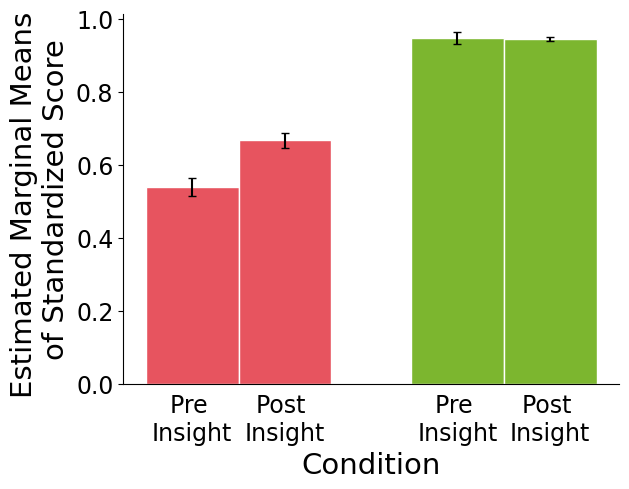

In [27]:
# figure data read out from emmean R analysis
emmean = pd.read_csv('data/fig3A_emmeans.csv')
labels = ['Pre \nInsight','Post \nInsight','Pre \nInsight','Post \nInsight']
pre_insight_proportions = [emmean.iloc[0]['emmean'],emmean.iloc[2]['emmean']]
pre_insight_err = [emmean.iloc[0]['SE'], emmean.iloc[2]['SE']]
post_insight_proportions = [emmean.iloc[1]['emmean'],emmean.iloc[3]['emmean']]
post_insight_err = [emmean.iloc[1]['SE'],emmean.iloc[3]['SE']]

x = np.array([0,1])
width = 0.35  # the width of the bars
color=['#E7545F', '#7CB62F']
plt.rcParams.update({'font.size': 21})

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre_insight_proportions, width, yerr=pre_insight_err, capsize=3, color=color, edgecolor='white')
rects2 = ax.bar(x + width/2, post_insight_proportions, width, yerr=post_insight_err, capsize=3, color=color,  edgecolor='white')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Estimated Marginal Means \nof Standardized Score')
ax.set_xticks(np.array([-.175,0.175,.825,1.175]))
ax.set_xticklabels(labels)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
ax.set_xlabel('Condition')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False)
plt.show()